In [1]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
from src.lstm_mapper_model import mapper_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data,  
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm
import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2025-01-16 11:21:14.453410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737026474.474200 1713346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737026474.479772 1713346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 11:21:14.505455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1737026490.241429 1713346 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [2]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

In [34]:
def load_and_concatenate_data(folder_paths, seq_data_function, n_seg=4):
    all_voltage_seq = []
    all_gamma_seq = []
    
    for folder in tqdm(folder_paths, desc="Processing folders"):
        voltage_sim, gamma_sim, _ = load_sim_data(folder) 
        voltage = (voltage_sim - np.mean(voltage_sim, axis=0)) / np.std(voltage_sim, axis=0)
        voltage = voltage.reshape(-1, 32, 32, 1)
        gamma = gamma_sim.reshape(-1, 2840, 1)
        voltage_seq, gamma_seq = seq_data_function(voltage, gamma, n_seg=n_seg)
        
        all_voltage_seq.append(voltage_seq)
        all_gamma_seq.append(gamma_seq)
        
    concatenated_voltage_seq = np.concatenate(all_voltage_seq, axis=0)
    concatenated_gamma_seq = np.concatenate(all_gamma_seq, axis=0)
    return concatenated_voltage_seq, concatenated_gamma_seq

#folder_paths = ["data34", "data35", "data36", "data37", "data38", "data39"]
#folder_paths = ["data46", "data49", "data50", "data51", "data52", "data54"] für 0.2-0.8 interpolation
voltage_seq, gamma_seq = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)
print("Concatenated Voltages Shape:", voltage_seq.shape)
print("Concatenated Permittivity Shape:", gamma_seq.shape)

Processing folders: 100%|██████████| 6/6 [01:57<00:00, 19.66s/it]


Concatenated Voltages Shape: (29976, 4, 32, 32, 1)
Concatenated Permittivity Shape: (29976, 2840, 1)


## Loading VAE Model and generating labels

In [35]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

_, _, latent_rep = vae.encoder.predict(gamma_seq)

Gewichte erfolgreich geladen.
937/937 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


## LSTM Mapper Training

In [36]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_seq,
    gamma_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [37]:
lstm_mapper = mapper_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Training mit EarlyStopping
history_mapper = lstm_mapper.fit(
    v_train_seq, 
    z_train, 
    epochs=100, 
    batch_size=8, 
    validation_split=0.1,
    callbacks=[stop_early]
)

Epoch 1/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.5034 - val_loss: 0.1791
Epoch 2/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.1681 - val_loss: 0.1538
Epoch 3/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1496 - val_loss: 0.1494
Epoch 4/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1417 - val_loss: 0.1417
Epoch 5/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1372 - val_loss: 0.1401
Epoch 6/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1329 - val_loss: 0.1370
Epoch 7/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1315 - val_loss: 0.1354
Epoch 8/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1276 - val_loss: 0.1355
Epoch 9/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1254 - val_loss: 0.1343
Epoch 10/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1254 - val_loss: 0.1338
Epoch 11/100
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1236 - val_loss: 0.1344
Epoch 12

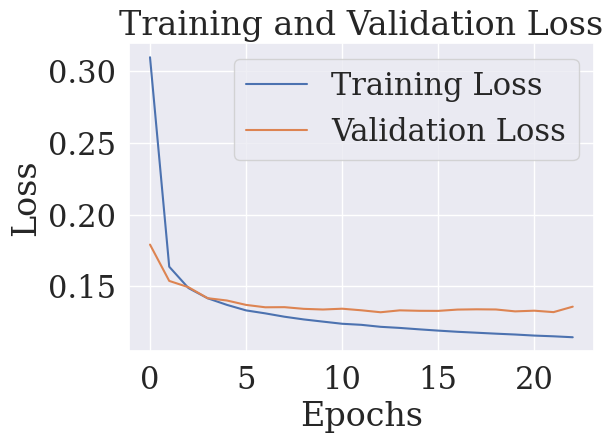

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [40]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_circle_interpolation_02_08.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_circle_interpolation_02_08.weights.h5


In [41]:
lstm_mapper.load_weights("weights/lstm_circle_interpolation_02_08.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [42]:
_, _, pred_latent = vae.encoder.predict(gamma_test)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)

pred_latent.shape, v_test_seq.shape, gamma_pred.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


((2998, 8), (2998, 4, 32, 32, 1), (2998, 2840))

## Load Test-Data

In [43]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data53")  #todo: adjust test data

voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)

voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_true_test = gamma_test_sim.reshape(-1, 2840, 1)

voltage_test_seq, _ = seq_data(voltage_test, gamma_true_test, n_seg=4)

pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [49]:
from src.performance_eval_2D import (compute_evaluation_metrics,
    plot_random_deviations, 
    plot_random_recon_examples, 
    plot_deviations_x_y,
    plot_deviations_perm,
    merge_plots_to_pdf,
    run_deviation_analysis)

In [50]:
#FE - Finite Elemente (Elemente)

Plot saved to: Abbildungen/random_deviations_circle_interpol_sim_02_08.pdf


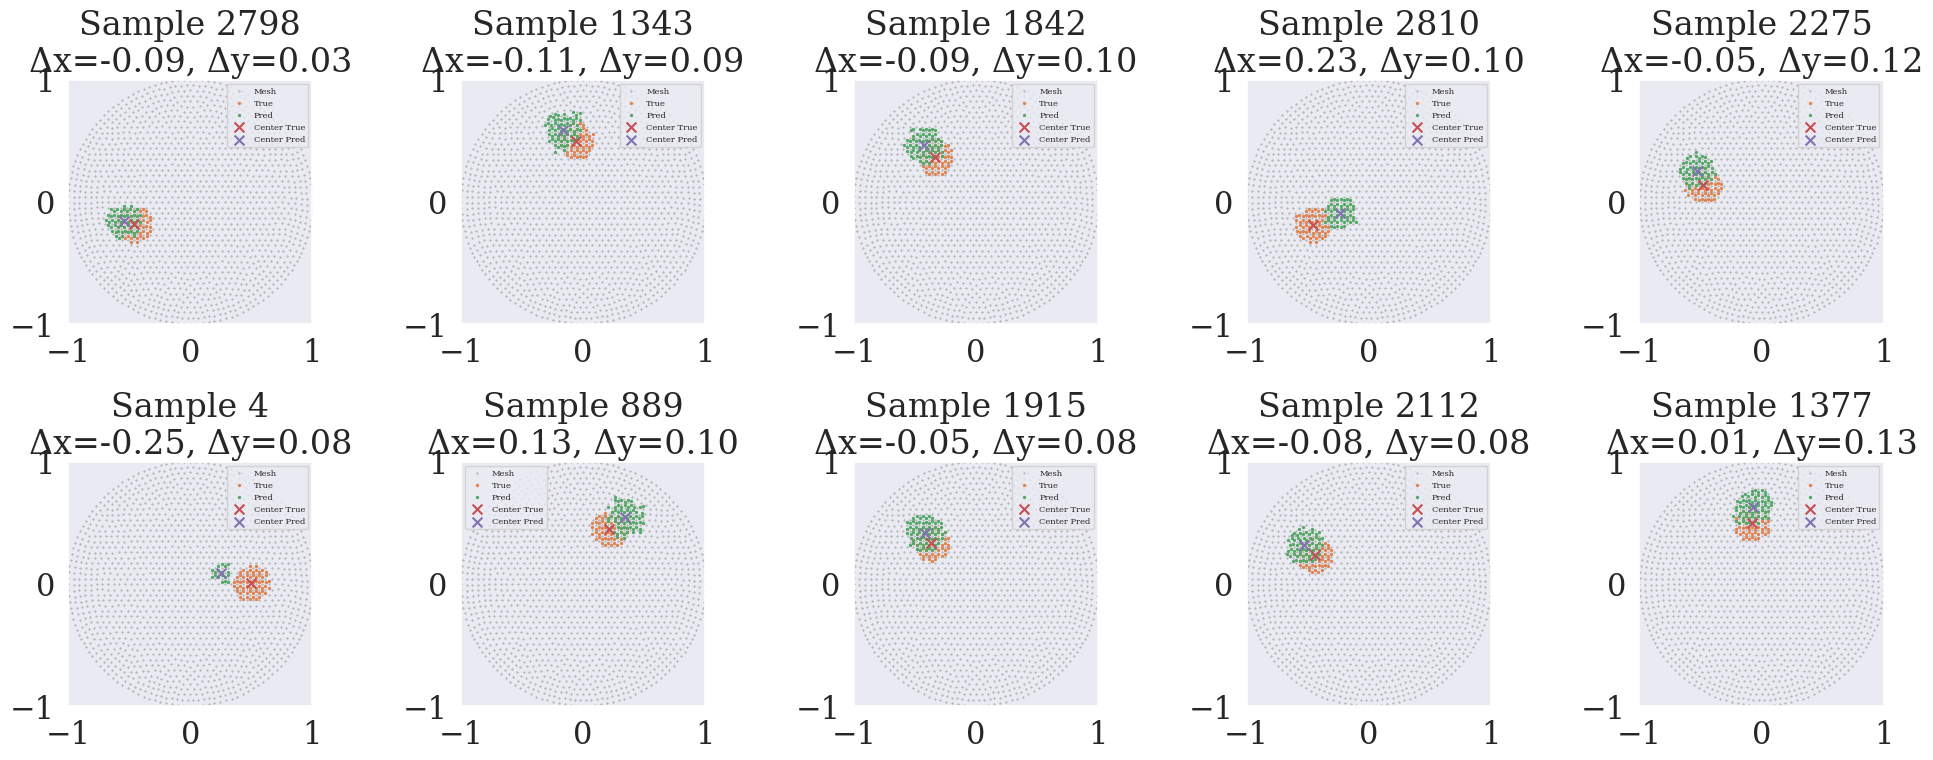

In [51]:
plot_random_deviations(mesh_obj, gamma_true_test, gamma_pred_test, num_samples=10, threshold=0.5, save=True, fpath='Abbildungen/',
                      fname='random_deviations_circle_interpol_sim_02_08.pdf')

Plot saved to: Abbildungen/random_reconstructions_circle_interpol_sim_02_08.pdf


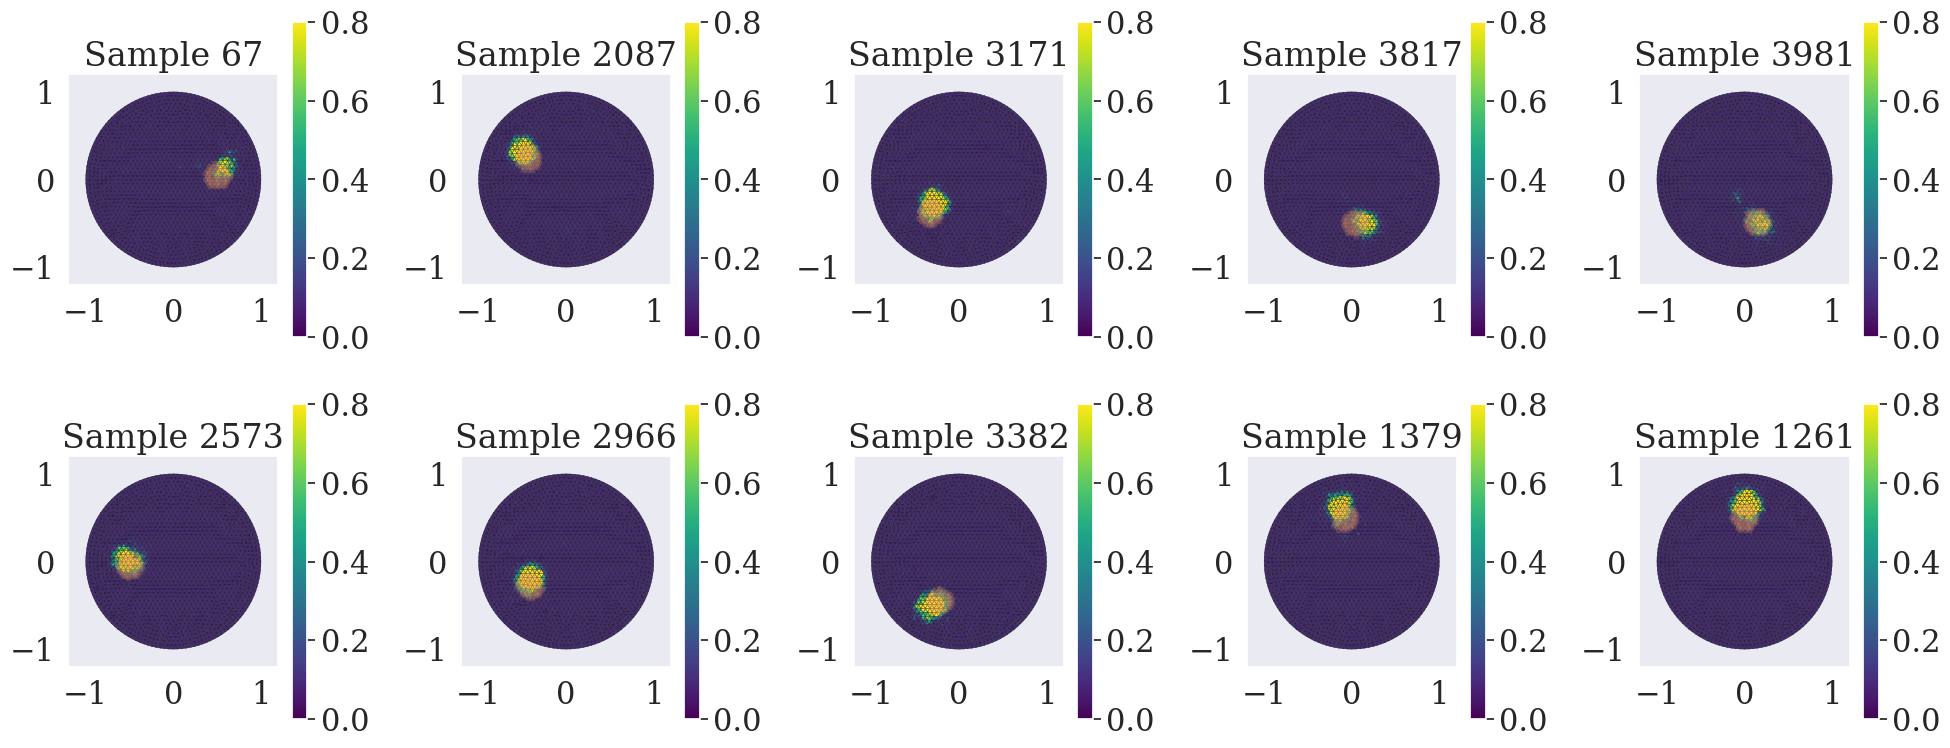

In [52]:
fig = plot_random_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, 
                               num_samples=10,
                               save=True, 
                               fpath='Abbildungen/',
                               fname='random_reconstructions_circle_interpol_sim_02_08.pdf')

Plot saved to: Abbildungen/position_circle_interpol_sim_02_08_deviations.pdf
Statistics saved to: Abbildungen/perm_deviation_stats.txt
Merged analysis plots saved as: Abbildungen/combined_circle_interpol_sim_02_08_deviations.pdf
Analysis complete. Final merged PDF saved as: Abbildungen/combined_circle_interpol_sim_02_08_deviations.pdf


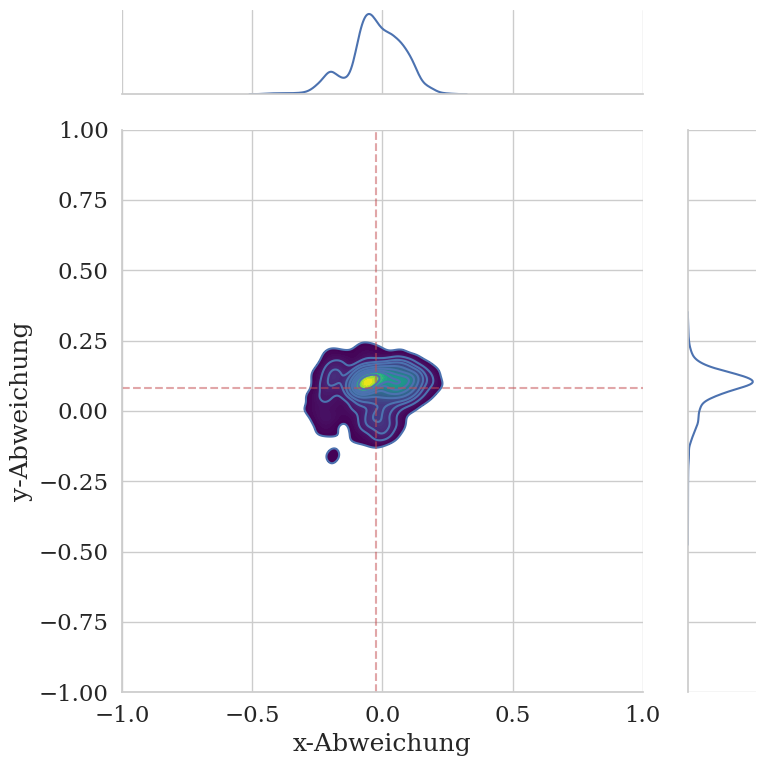

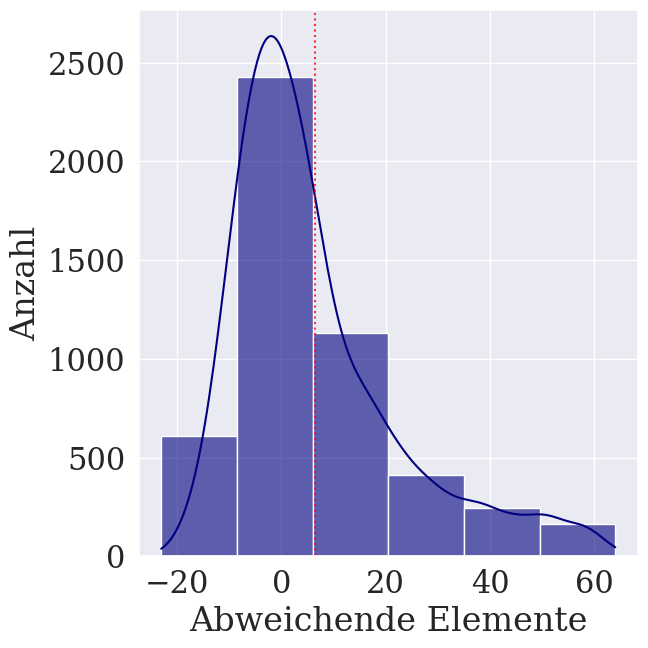

In [53]:
fpath = 'Abbildungen/'
base_fname = 'circle_interpol_sim_02_08'

run_deviation_analysis(gamma_true_test, gamma_pred_test, mesh_obj, fpath, base_fname)